ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **25Jan21**

# 01. Introduction
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Target Function](#f)
* [Collocation Points](#colpts)
* [Fourier Basis Functions w/ Least-Squares Residual](#fourier-lsq)
  - [Linear Combination of Non-Linear Basis Functions](#fourier-lincomb)
  - [Optimal Combination Coefficients](#fourier-optimal-coeff)
  - [Best Approximant Function](#fourier-approximant)
  - [Results](#fourier-res)
  - [Errors](#fourier-error)
* [Lagrange Polynomial Basis Functions w/ Least-Squares Residual](#lagrange-lsq)
  - [Linear Combination of Non-Linear Basis Functions](#lagrange-lincomb)
  - [Optimal Combination Coefficients](#lagrange-optimal-coeff)
  - [Best Approximant Function](#lagrange-approximant)
  - [Results](#lagrange-res)
  - [Errors](#lagrange-error)
* [Experiments on the Fly](#experiments)
---

## [Objectives](#toc)<a id="obj"></a>

 + Introductory comments on variational forms and basis functions.
 + Elementary use of basis functions to approximate a given function: linear least-squares method
 + Elementary description of a least-squares Galerkin spectral element method to solve 1-D Poisson problem.
 + [Handwritten notes in OneNote](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EiT9S8dWWQ5LuvalDfeDuOoBs-_tgLPFR83xU6WumdI9xg?e=fQXd40).

## [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* target function $f:\Reals\rightarrow\Reals$ how can we systematically compute an approximant $g:\Reals\rightarrow\Reals$? Why would anyone care about this? The ability to approximate a given $f$ helps building methods to approximate $f$ when it is not explicitly given but sought as the solution of a mathematical problems such as an ODE or PDE. There is also intrinsic value in being able to approximate a function or its values as in signal processing.

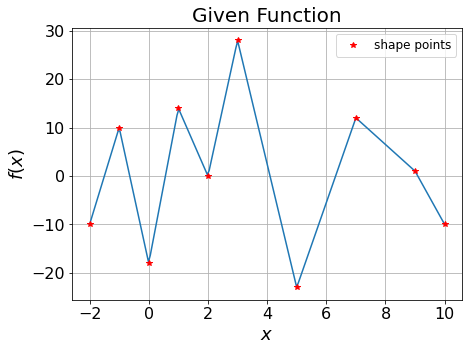

In [1]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import Function   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10),(-1,10),(0,-18),(1,14),(2,0),(3,28),(5,-23),(7,12),(9,1),(10,-10)]

f = Function(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, shape_pts=True, title='Given Function')

In [2]:
'''Example code for plotting (not used)'''
import matplotlib.pyplot as plt
%matplotlib inline
def plot(f, g=None, n_plot_pts=100, shape_pts=False):
    
    x = np.linspace(f.shape_pts[0][0], f.shape_pts[-1][0], n_plot_pts)
    y = f.values(x)
    
    plt.figure(1, figsize=(7, 5))

    if g:
        plt.plot(x, y, label='f')
    else:
        plt.plot(x, y)
    
    if shape_pts:
        plt.plot([p[0] for p in f.shape_pts], [p[1] for p in f.shape_pts],'r*',label='shape points')
    
    if g:
        plt.plot(g[0], g[1], '--r', label='g')
    
    plt.xlabel(r'$x$',fontsize=18)
    if g:
        plt.ylabel(r'$f(x), g(x)$', fontsize=18)
    else:
        plt.ylabel(r'$f(x)$', fontsize=18)
    
    if g:
        plt.title('Function Comparison', fontsize=20)
    else:
        plt.title('Given Function',fontsize=20)
        
    if shape_pts or g:
        plt.legend(loc='best',fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.show()

## [Collocation Points](#toc)<a id="colpts"></a>

If $g$ is obtainable, how would we compare to $f$? On the whole $\Reals$? This prompts the simple idea of computing $g$ to approximate $f$ on a selected number of points in $\Reals$. Hence, let's select a number of *collocation* abscissa points and form the *set* $\{\tilde{x}_i \mid i=1,\ldots,m\}$ or vector $\tilde{\xvec}\in\Reals^m$. Now we can ask a more definite question. How do we make $g$ and $f$ to be very close when evaluated at the collocation points? Ideally if $m\rightarrow\infty$ then $f\approx g$ to a very good approximation.

In [3]:
'''Collocation abscissa points'''
import numpy as np

min_x = shape_pts[0][0]
max_x = shape_pts[-1][0]

m = 25

x_tilde_pts = np.linspace(min_x, max_x, m)

## [Fourier Basis Functions w/ Least-Squares Residual](#toc)<a id="fourier-lsq"></a>

Using Fourier basis functions 

\begin{equation*}
   V := \{\cos(k\,\kappa\,x), \,\sin(k\,\kappa\,x)\, \mid \, k=0,\ldots,N\},
\end{equation*}

and the collocation points $\tilde{\xvec}$, compute the best approximant function of $f:\Reals\rightarrow \Reals$ by minimizing the residual vector, as defined below, on the collocation points.

### [Linear Combination of Non-Linear Basis Functions](#toc)<a id="fourier-lincomb"></a>

A powerful method used to compute an approximant $g$ can be built using the simple structure of a given basis functions set. An approximant non-linear function $g$ can be sougth as a **linear combination** of **nonlinear functions**:

\begin{equation*}
 g(x) := \sum\limits_{k=0}^N \alpha_k\,\cos(k\,\kappa\,x) + \beta_k\,\sin(k\,\kappa\,x) \quad\  \forall \quad\ x\in\Reals.
\end{equation*}

Here there are $n=2N+1$ real coefficients $\alpha_k$ and $\beta_k$, and $\kappa$ is the wavenumber. For future reference the vector of coefficients $\cvec \in \Reals^n$, is defined as follows:  $\cvec = \begin{pmatrix}
 \alpha_0 \\ 
 \alpha_1 \\ 
 \beta_1  \\ 
 \vdots \\
 \alpha_N \\ 
 \beta_N \\
\end{pmatrix}$. Furthermore the $g$ function is written with the explicit dependence on the coefficients as parameters:

\begin{equation*}
 g(x; \cvec) = \sum\limits_{k=0}^N \alpha_k\,\cos(k\,\kappa\,x) + \beta_k\,\sin(k\,\kappa\,x) \quad\  \forall \quad\ x\in\Reals.
\end{equation*}

How could we compute the *best* values for these coefficients so that $g(\tilde{x}_i,\cvec)$ and $f(\tilde{x}_i)$ are *sufficiently close* for all $\tilde{x}_i$?

Let's define the vector $\tilde{\fvec}\in\Reals^m$ of values $\tilde{f}_i = f(\tilde{x}_i)$ as 
$\tilde{\fvec} = \begin{pmatrix}
 f(\tilde{x}_1) \\ 
 f(\tilde{x}_2) \\ 
 \vdots  \\ 
 f(\tilde{x}_m) \\ 
\end{pmatrix}$ and similarly the vector-valued function of a vector argument, $\tilde{\gvec}:\Reals^n\rightarrow\Reals^m$, that is,
$\tilde{\gvec}(\cvec) = \begin{pmatrix}
 g(\tilde{x}_1,\cvec) \\ 
 g(\tilde{x}_2,\cvec) \\ 
 \vdots  \\ 
 g(\tilde{x}_m,\cvec) \\ 
\end{pmatrix}$, where $\cvec$ is the vector of coefficients. Note that $\tilde{\gvec}$ is a **linear function** of its argument, that is,

\begin{equation*}
 \boxed{\tilde{\gvec}(\cvec) = \tilde{\Amtrx}\,\cvec},
\end{equation*}

where $\tilde{\Amtrx}$ is a $m\times n$ real matrix (called here the basis functions collocation matrix), that is:

$\overset{(m \times n)}{\tilde{\Amtrx}} =  \begin{pmatrix}
1 & \cos(\kappa\,\tilde{x}_1) & \sin(\kappa\,\tilde{x}_1) & \cos(2\kappa\,\tilde{x}_1) & \sin(2\kappa\,\tilde{x}_1) & \ldots & \cos(N\kappa\,\tilde{x}_1) & \sin(N\kappa\,\tilde{x}_1)  \\
1 & \cos(\kappa\,\tilde{x}_2) & \sin(\kappa\,\tilde{x}_2) & \cos(2\kappa\,\tilde{x}_2) & \sin(2\kappa\,\tilde{x}_2) & \ldots & \cos(N\kappa\,\tilde{x}_2) & \sin(N\kappa\,\tilde{x}_2)  \\
\vdots  & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \cos(\kappa\,\tilde{x}_m) & \sin(\kappa\,\tilde{x}_m) & \cos(2\kappa\,\tilde{x}_m) & \sin(2\kappa\,\tilde{x}_m) & \ldots & \cos(N\kappa\,\tilde{x}_m) & \sin(N\kappa\,\tilde{x}_m)  \\
 \end{pmatrix}$.

This important linear relationship is the whole point of using a linear combination of the basis functions as it will be apparent next.

In [4]:
'''Build the basis function evaluation matrix and target function vector at the collocation points'''

import math

wavelength = max_x - min_x
kappa = 2*math.pi/wavelength

N = 5 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import build_fourier_matrix  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

a_tilde_mtrx = build_fourier_matrix(kappa, N, x_tilde_pts)
f_tilde_vec = np.array(f.values(x_tilde_pts))

### [Optimal Combination Coefficients](#toc)<a id="fourier-optimal-coeff"></a>

It is natural to form the residual function, $\tilde{\rvec}:\Reals^m\rightarrow\Reals^m$ evaluated at $\cvec$, that is, $\tilde{\rvec}(\cvec) := \tilde{\fvec} - \tilde{\gvec}(\cvec)$ and ask the question how to compute $\cvec^*$ so to minimize the magnitude of $\rvec(\cvec^*)$? Arguably the *best* method is to minimize the sum of the squares of the residual vector components,

\begin{equation*}
 \phi(\cvec^*) = \min\limits_{\cvec\,\in\,\Reals^n} \, \norm{\tilde{\rvec}(\cvec)}^2_2,
\end{equation*}

that is to say, to compute $\cvec^*$ using the least-squares method. To make progress to compute $\cvec^*$, let's rewrite the previous equation as follows

\begin{equation*}
 \phi(\cvec^*) = \min\limits_{\cvec\,\in\,\Reals^n} \, (\tilde{\Amtrx}\,\cvec-\tilde{\fvec})\cdot(\tilde{\Amtrx}\,\cvec-\tilde{\fvec})
\end{equation*}

We can now impose the optimality condition (directional derivative set to zero in any direction)

\begin{equation*}
 dd_\thetavec \phi(\cvec^*) = 0 \quad \forall \quad \thetavec\,\in\,\Reals^n .
\end{equation*}

This leads to the normal matrix equation

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\cvec^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided in this approximation area by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values. Therefore everything done to this point depends also on a choice of collocation points $\tilde{\xvec}$. To make this clear, the optimal coefficient is denoted $\tilde{\cvec}^*$.


In [5]:
'''Compute optimal coefficient vector'''

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank')
    c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)

A is full rank


### [Best Approximant Function](#toc)<a id="fourier-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\cdot)$ is the Fourier basis functions evaluation matrix on any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec_\text{best}(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

In [6]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    return build_fourier_matrix(kappa, N, x_pts)@c_tilde_star_vec

### [Results](#toc)<a id="fourier-res"></a>

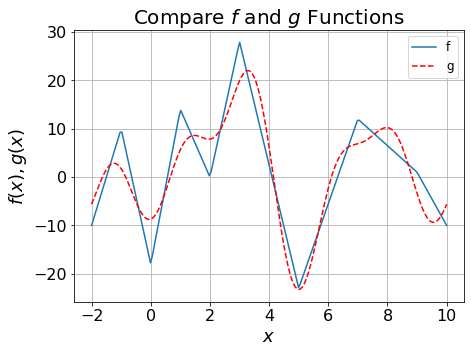

In [7]:
'''Plot comparison of f and g_vec'''

n_pts = max(2 * m, 200)
x_pts = np.linspace(min_x, max_x, n_pts)

g_vec = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_vec), n_plot_pts=n_pts, title='Compare $f$ and $g$ Functions')

### [Errors](#toc)<a id="fourier-error"></a>

**Local errors are too pessimistic.**

In [8]:
'''Local error depends on the number of sampling points'''

n_pts = 50
x_pts = np.linspace(min_x, max_x, n_pts)

f_vec = f.values(x_pts)
g_vec = g_best_vec_func(x_pts)

shift = False

if shift:
    min_val = min(min(f_vec), min(g_vec))
    v_shift = min_val
    f_vec += abs(v_shift+1)
    g_vec += abs(v_shift+1)

print('mean local rel error [%] = ', np.mean(abs((g_vec-f_vec)/f_vec*100.0)))
print('std local rel error [%] = ', np.std(abs((g_vec-f_vec)/f_vec*100.0)))
print('max local rel error [%] = ', np.max(abs((g_vec-f_vec)/f_vec*100.0)))
print('min local rel error [%] = ', np.min(abs((g_vec-f_vec)/f_vec*100.0)))

mean local rel error [%] =  120.16394708537601
std local rel error [%] =  259.99754345682203
max local rel error [%] =  1575.4447345731407
min local rel error [%] =  1.3126017180002167


**Pitfall of area-based error.**

In [9]:
'''Area-based error'''

from scipy.integrate import quad

def f_integrand(x):
    return f.values(np.array(x))
def g_integrand(x):
    return g_best_vec_func(np.array(x))

f_integral = quad(f_integrand, min_x, max_x)
print('Area under f =', f_integral)

g_integral = quad(g_integrand, min_x, max_x)
print('Area under g =', g_integral)

print('rel error [%] = ', abs(g_integral[0]-f_integral[0])/f_integral[0]*100)

Area under f = (17.499999999999982, 1.942890293094022e-14)
Area under g = (15.303655338126939, 1.1657816291832184e-12)
rel error [%] =  12.550540924988832


**Error based on the underlying function theory.**

The Lebesgue integral norm, $L_2(\Omega)$, of a function is defined as

\begin{equation*}
 \norm{f}_{L_2(\Omega)} = \sqrt{\int\limits_{\Omega} \, f^2(x)\,dx} ,
\end{equation*}

and can be used for error estimation of function approximation. This norm and other equivalent norms play an important role in functional theory and finite element methods. Note:

\begin{equation*}
 \norm{f-g_\text{best}}_{L_2(\Omega)} = \sqrt{\int\limits_{\Omega} \, \bigl(f(x) - g_\text{best}(x)\bigr)^2\,dx} .
\end{equation*}

In [10]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array(x))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, min_x, max_x, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    g_vec = g_best_vec_func(np.array(x))
    f_x = f.values(np.array(x))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x, max_x, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 36.7238277275933

||f-g||_L2 = 13.421287339176745

Relative error [%] = 36.17698420677849


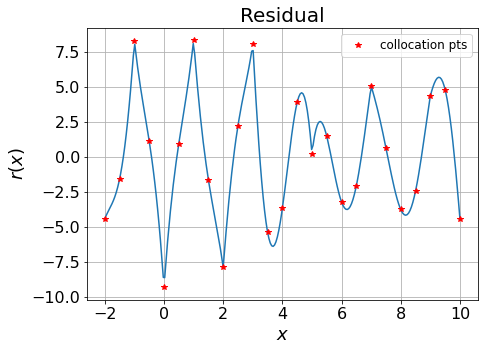

In [11]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
%matplotlib inline

n_pts = max(4 * m, 250)
x_pts = np.linspace(min_x, max_x, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
  
plt.figure(1, figsize=(7, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title('Residual', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

## [Lagrange Polynomial Basis Functions w/ Least-Squares Residual](#toc)<a id="lagrange-lsq"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:\Reals\rightarrow \Reals$.

### [Linear Combination of Non-Linear Basis Functions](#toc)<a id="lagrange-lincomb"></a>

A polynomial "Lagrange" basis functions can also be used

\begin{equation*}
   V := \{x^k \, \mid \, k=0,\ldots,N\}
\end{equation*}

where $N$ is the degree of the basis. This set of basis functions is much less flexible than the Fourier counterpart, unless the function to be approximated is a polynomial function.

In [12]:
'''Build the basis function evaluation matrix and target function vector at the collocation points'''

try:    
    from engy_5310.toolkit import build_lagrange_matrix  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
degree = 8

a_tilde_mtrx = build_lagrange_matrix(degree, x_tilde_pts)
f_tilde_vec = np.array(f.values(x_tilde_pts))

### [Optimal Combination Coefficients](#toc)<a id="lagrange-optimal-coeff"></a>

Solve the normal equations

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided in this approximation area by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values.


In [13]:
'''Compute optimal coefficient vector'''

#c_vec = solve(a_mtrx.transpose()@a_mtrx, a_mtrx.transpose()@f_vec, pivot_tol=1e-9, zero_tol=1e-3)

import numpy as np
c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)

### [Best Approximant Function](#toc)<a id="lagrange-approximant"></a>

The best approximant non-linear function $g^*:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec^*(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\cdot)$ is the Fourier basis functions evaluation matrix on any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec^*(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

In [14]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    return build_lagrange_matrix(degree, x_pts)@c_tilde_star_vec

### [Results](#toc)<a id="lagrange-res"></a>

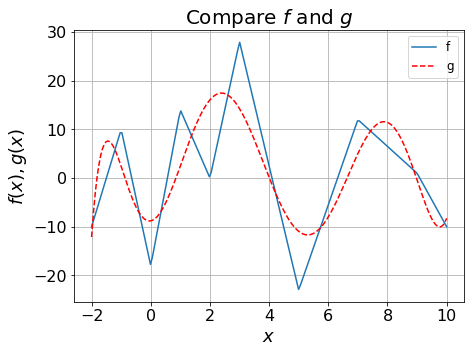

In [15]:
'''Plot comparison of f and g_vec'''

n_pts = max(2 * m, 200)
x_pts = np.linspace(min_x, max_x, n_pts)

g_vec = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_vec), n_plot_pts=n_pts, title='Compare $f$ and $g$')

### [Errors](#toc)<a id="lagrange-error"></a>

In [16]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array(x))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, min_x, max_x, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    g_vec = g_best_vec_func(np.array(x))
    f_x = f.values(np.array(x))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x, max_x, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 31.179813012464635

||f-g||_L2 = 21.13593417617158

Relative error [%] = 56.97175968022836


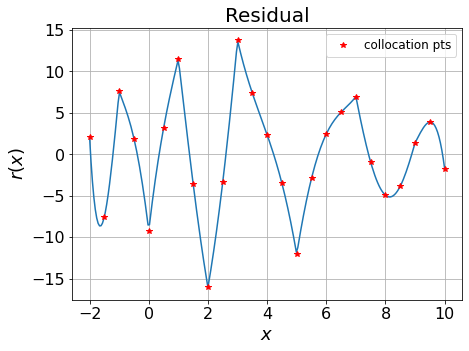

In [17]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
%matplotlib inline

n_pts = max(4 * m, 250)
x_pts = np.linspace(min_x, max_x, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
  
plt.figure(1, figsize=(7, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title('Residual', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

## [Experiments on the Fly](#toc)<a id="experiments"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:\Reals\rightarrow \Reals$.

10


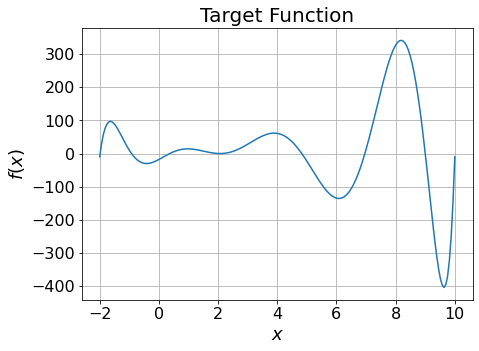

In [18]:
'''Consider another function'''

f = Function(shape_pts, type='lagrange')
  
f.plot(n_plot_pts=200, title='Target Function')

In [19]:
'''Collocation abscissa points'''

min_x = shape_pts[0][0]
max_x = shape_pts[-1][0]

m = 50

x_tilde_pts = np.linspace(min_x, max_x, m)

In [20]:
'''Build the basis function evaluation matrix and target function vector at collocation points'''
   
degree = 5

a_tilde_mtrx = build_lagrange_matrix(degree, x_tilde_pts)
f_tilde_vec = f.values(x_tilde_pts)

In [21]:
'''Compute optimal coefficient vector'''

c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)

In [22]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    return build_lagrange_matrix(degree, x_pts)@c_tilde_star_vec

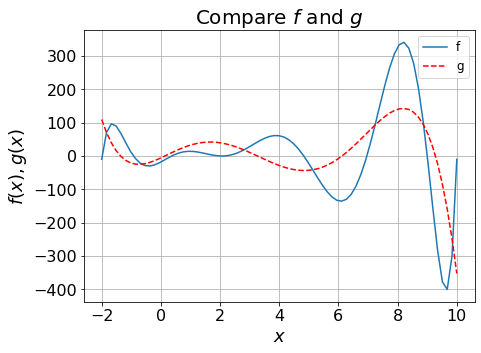

In [23]:
'''Plot comparison of f and g_vec'''

n_pts = int(1.5 * m)
x_pts = np.linspace(min_x, max_x, n_pts)

g_vec = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_vec), n_plot_pts=n_pts, title='Compare $f$ and $g$')

In [24]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

print('')

g2_integral, error = quad(g2_integrand, min_x, max_x, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x, max_x, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 473.3517019907066

||g||_L2 = 250.63620091170395

||f-g||_L2 = 337.10181141997305

Relative error [%] = 71.2159288753527
